# Project - Regressors

## Initialization

Import libraries

In [1]:
import glob
import os

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, r2_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_fscore_support, precision_recall_curve, auc

from operator import itemgetter, attrgetter

from matplotlib import pyplot as plt

#### Prepare parallel kernel

*Install [here](https://ipyparallel.readthedocs.io/en/latest/), define the number of engines and click '**Start**' in the* **iPython Clusters** *tab.*

Import parallel computing libraries and register processors

In [2]:
from ipyparallel import Client
from ipyparallel.joblib import IPythonParallelBackend
from joblib import Parallel, parallel_backend, register_parallel_backend

On Noto, run `ipcontroller --ip="*"`

In [3]:
c = Client(profile='default')
print('profile:', c.profile)
print("IDs:", c.ids) # Process id numbers
bview = c.load_balanced_view()
register_parallel_backend('ipyparallel',
                          lambda : IPythonParallelBackend(view=bview))

profile: default
IDs: [0, 1, 2, 3]


---

## Function definitions

Read datasets

In [4]:
def plot_importance(feature_importance_sorted, n, type_of_search):
    
    plt.figure(figsize=(15,5))
    x = np.arange(n)
    y = [feature_importance_sorted[i][1] for i in range(n)]
    labels = [feature_importance_sorted[i][0] for i in range(n)]
    ax = sns.barplot(y,x,orient="h");
    plt.xlabel("Importance fraction", fontsize = 12)
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    plt.yticks(x,labels, fontsize = 15)
    plt.title('Most important feature: {}'.format(type_of_search), fontsize = 15)
    plt.show()

In [5]:
def pp_rf(test_size):
    
    list_of_files = glob.glob('50_by_100/Full*.csv') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    
    print(latest_file)

    df_raw = pd.read_csv(latest_file, index_col=0)
    df_raw.sort_index(inplace = True, ascending = True)
    df_raw.sort_index(inplace = True, axis = 1)

    y = df_raw.COVID.copy()
    X = df_raw.drop(columns = ['COVID']).copy()
    
    X_types = dict(X.dtypes)
    features = list(X.columns)
    
    train = np.random.rand(len(df_raw))> test_size

    X_train = X[train]
    X_test = X[~train]

    y_train = y[train].tolist()
    y_test = y[~train].tolist()

    return X, X_train, X_test, y, y_train, y_test

## Random Forest Regressor

We will compare two methods, which are grid search and random search.

In [6]:
X, X_train, X_test, y, y_train, y_test = pp_rf(0.3)

50_by_100\Full-2020_05_09-19_39_13-X_raw_disease_50_target_100_3050_by_101.csv


In [7]:
rf_reg = RandomForestRegressor(n_jobs=-1)

### Grid search

To avoid having too high a computational time, we will focus on 2 of the mot important parameters that are max depth and the number of estimators.

#### Max Depth

This parameter is the depth of the trees, which is one of the most important. We range it between 4 (anything lower seems too low and increases computational time without much results) and 15.

#### Number of estimators

This parameter is the number of trees that are going to be generated. Here the choice of the number of trees will mostly affect the computational time. Let's set the values between 100 and 5'000 and see the effects.

In [8]:
#n_estimators = range(10,5000,50)
n_estimators = [100, 200, 500, 1000, 2000, 5000]
#criterion = ['mse', 'mae']
criterion = ['mse']
max_depth = range(5,50,10)
#min_samples_split = range(2,100,2)
min_samples_split = [2]
#min_samples_leaf = range(2,100, 2)
min_samples_leaf = [2]
#max_features = ['sqrt', 'log2', None]
max_features = ['sqrt']
#bootstrap = [True, False]
bootstrap = [True]

grid_parameters = {'n_estimators' : n_estimators,
                   'criterion' : criterion,
                   'max_depth' : max_depth,
                   'min_samples_split' : min_samples_split,
                   'min_samples_leaf' : min_samples_leaf,
                   'max_features' : max_features,
                   'bootstrap' : bootstrap}

Let's use the default 5 folds of cross validation.

In [9]:
grid_reg = GridSearchCV(rf_reg,
                        param_grid = grid_parameters,
                        return_train_score = True,
                        verbose = 3)

In [10]:
with parallel_backend('ipyparallel'):
    grid_reg.fit(X_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.6min finished


Let's check which model is the best.

In [11]:
grid_best_score = grid_reg.best_score_
grid_best_parameters = grid_reg.best_params_
grid_best_n_estimators = grid_best_parameters.get('n_estimators')
grid_best_criterion = grid_best_parameters.get('criterion')
grid_best_max_depth = grid_best_parameters.get('max_depth')
grid_best_min_samples_split = grid_best_parameters.get('min_samples_split')
grid_best_min_samples_leaf = grid_best_parameters.get('min_samples_leaf')
grid_best_max_features = grid_best_parameters.get('max_features')
grid_best_bootstrap = grid_best_parameters.get('bootstrap')


print('Grid search best_score: {:.5}'.format(grid_best_score))

print('Grid best n_estimators: {}'.format(grid_best_n_estimators))
print('Grid best criterion: {}'.format(grid_best_criterion))
print('Grid best max_depth: {}'.format(grid_best_max_depth))
print('Grid best min_samples_split: {}'.format(grid_best_min_samples_split))
print('Grid best min_samples_leaf: {}'.format(grid_best_min_samples_leaf))
print('Grid best max_features: {}'.format(grid_best_max_features))
print('Grid best bootstrap: {}'.format(grid_best_bootstrap))

Grid search best_score: -0.54571
Grid best n_estimators: 2000
Grid best criterion: mse
Grid best max_depth: 5
Grid best min_samples_split: 2
Grid best min_samples_leaf: 2
Grid best max_features: sqrt
Grid best bootstrap: True


In [12]:
grid_best_parameters = {'n_estimators' : [grid_best_n_estimators],
                        'criterion' : [grid_best_criterion],
                        'max_depth' : [grid_best_max_depth],
                        'min_samples_split' : [grid_best_min_samples_split],
                        'min_samples_leaf' : [grid_best_min_samples_leaf],
                        'max_features' : [grid_best_max_features],
                        'bootstrap' : [grid_best_bootstrap]}

In [13]:
grid_reg_best = GridSearchCV(rf_reg,
                             param_grid = grid_best_parameters,
                             return_train_score = True,
                             verbose = 3)

In [14]:
with parallel_backend('ipyparallel'):
    grid_reg_best.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.2s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s finished


Let's apply it to our validation set.

In [15]:
grid_y_pred = grid_reg_best.predict(X_test)

In [16]:
mae = abs(grid_y_pred - y_test)/y_test
print("Accuracy: {:.2%}".format(1 - np.mean(mae)))

Accuracy: -312.63%


Given this accuracy, we can take a deeper look into the results.

#### Feature importance

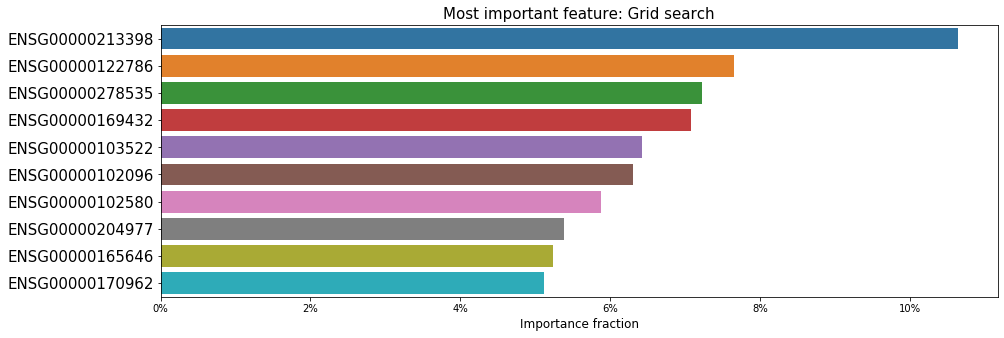

In [17]:
grid_feature_importances = [(list(X.columns)[i], grid_reg_best.best_estimator_.feature_importances_[i])
                            for i in range(len(list(X.columns)))]
grid_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(grid_feature_importances, 10, 'Grid search')

In [18]:
print(r2_score(y_test,grid_y_pred))

0.0015351642347916084


#### Feature selection

Let's try to run the model again, but this time selecting only the most impacting features to save us some work and let's compare the results.

In [19]:
grid_selected_features = [grid_feature_importances[i][0]
                          for i in range(15)]
grid_X_train_sel = X_train[grid_selected_features]
grid_X_test_sel = X_test[grid_selected_features]

In [20]:
with parallel_backend('ipyparallel'):
    grid_reg.fit(grid_X_train_sel, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.1min finished


In [21]:
grid_best_score_sel = grid_reg.best_score_
grid_best_parameters_sel = grid_reg.best_params_
grid_best_n_estimators_sel = grid_best_parameters_sel.get('n_estimators')
grid_best_criterion_sel = grid_best_parameters_sel.get('criterion')
grid_best_max_depth_sel = grid_best_parameters_sel.get('max_depth')
grid_best_min_samples_split_sel = grid_best_parameters_sel.get('min_samples_split')
grid_best_min_samples_leaf_sel = grid_best_parameters_sel.get('min_samples_leaf')
grid_best_max_features_sel = grid_best_parameters_sel.get('max_features')
grid_best_bootstrap_sel = grid_best_parameters_sel.get('bootstrap')


print('Grid search best_score: {:.5}'.format(grid_best_score_sel))

print('Grid best n_estimators: {}'.format(grid_best_n_estimators_sel))
print('Grid best criterion: {}'.format(grid_best_criterion_sel))
print('Grid best max_depth: {}'.format(grid_best_max_depth_sel))
print('Grid best min_samples_split: {}'.format(grid_best_min_samples_split_sel))
print('Grid best min_samples_leaf: {}'.format(grid_best_min_samples_leaf_sel))
print('Grid best max_features: {}'.format(grid_best_max_features_sel))
print('Grid best bootstrap: {}'.format(grid_best_bootstrap_sel))

Grid search best_score: -0.63375
Grid best n_estimators: 2000
Grid best criterion: mse
Grid best max_depth: 5
Grid best min_samples_split: 2
Grid best min_samples_leaf: 2
Grid best max_features: sqrt
Grid best bootstrap: True


In [22]:
grid_best_parameters_sel = {'n_estimators' : [grid_best_n_estimators_sel],
                            'criterion' : [grid_best_criterion_sel],
                            'max_depth' : [grid_best_max_depth_sel],
                            'min_samples_split' : [grid_best_min_samples_split_sel],
                            'min_samples_leaf' : [grid_best_min_samples_leaf_sel],
                            'max_features' : [grid_best_max_features_sel],
                            'bootstrap' : [grid_best_bootstrap_sel]}

In [23]:
grid_reg_best_sel = GridSearchCV(rf_reg,
                                 param_grid = grid_best_parameters_sel,
                                 return_train_score = True,
                                 verbose = 3)

In [24]:
with parallel_backend('ipyparallel'):
    grid_reg_best_sel.fit(grid_X_train_sel, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000, score=(train=0.072, test=-1.484), total=   4.8s
[CV] bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000, score=(train=0.068, test=-1.296), total=   3.5s
[CV] bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s


[CV]  bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000, score=(train=0.079, test=-0.030), total=   3.3s
[CV] bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000, score=(train=0.069, test=-0.047), total=   3.2s
[CV] bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000, score=(train=0.075, test=-0.320), total=   3.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.3s finished


In [25]:
grid_y_pred_sel = grid_reg_best_sel.predict(grid_X_test_sel)

In [26]:
mae = abs(grid_y_pred_sel - y_test)/y_test
print("Accuracy: {:.2%}".format(1 - np.mean(mae)))

Accuracy: -313.19%


In [27]:
print(r2_score(y_test,grid_y_pred_sel))

-0.0005582621407542732
